# Imports

In [167]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt

# Loading the Data

In [74]:
filepath = 'all_data.csv'
original_df = pd.read_csv(filepath)

In [75]:
# initial look at the data
original_df.head()

,nb_id,error,longer_beginning,longer_ending,has_author,has_equation,jupyter_prop,output_cell_prop,markdown_prop,num_contrib,...,has_comments,md_frequency,has_title,num_commits,md_format,non_exec_prop,exec_inorder,exec_skips,has_error,speaking_language
0,294,nb_file,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,329,nb_file,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,580,nb_file,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,594,NaN,True,False,False,False,0.507588,1.0,0.044444,3.0,...,False,0.068182,True,1.0,True,0.0,1.0,1.809524,False,English
4,921,NaN,False,True,False,False,0.999968,0.0,0.295455,1.0,...,False,0.279070,True,1.0,True,1.0,NaN,NaN,False,Estonian


# Cleaning the Data

- get rid of rows with `nb_file`, `api`, and `no_code` errors, as these have no data associated with them
- filter to English and `python` notebooks

## Notebook Errors

In [76]:
# filter out nb_file errors
nb_errors = original_df[original_df['error'] == 'nb_file'].index
nb_filtered = original_df.drop(nb_errors, inplace = False)

# filter out api errors
api_errors = nb_filtered[nb_filtered['error'] == 'api'].index
api_filtered = nb_filtered.drop(api_errors, inplace = False)

# filter out no_code errors
code_errors = api_filtered[api_filtered['error'] == 'no_code'].index
code_filtered = api_filtered.drop(code_errors, inplace = False)

In [77]:
# we should no longer need the error column, since it was only used as filtering criteria
final_error_filtered = code_filtered.drop(["error"], axis = 1)

# initial look at the error-filtered data
final_error_filtered.head()

,nb_id,longer_beginning,longer_ending,has_author,has_equation,jupyter_prop,output_cell_prop,markdown_prop,num_contrib,image_prop,...,has_comments,md_frequency,has_title,num_commits,md_format,non_exec_prop,exec_inorder,exec_skips,has_error,speaking_language
3,594,True,False,False,False,0.507588,1.000000,0.044444,3.0,0.000000,...,False,0.068182,True,1.0,True,0.000000,1.0,1.809524,False,English
4,921,False,True,False,False,0.999968,0.000000,0.295455,1.0,NaN,...,False,0.279070,True,1.0,True,1.000000,NaN,NaN,False,Estonian
6,1222,True,False,False,False,1.000000,0.000000,0.161290,1.0,NaN,...,True,0.333333,False,2.0,True,0.961538,NaN,NaN,False,English
7,1447,True,False,False,False,0.970851,0.011364,0.375887,1.0,0.000000,...,True,0.621429,True,1.0,True,0.988636,NaN,NaN,False,English
8,1589,NaN,NaN,False,NaN,0.714130,0.538462,0.000000,1.0,0.142857,...,False,NaN,False,1.0,NaN,0.000000,1.0,1.000000,False,NaN


## English and Python Notebooks

In [78]:
# filter down to only english notebooks and notebooks with no markdown cells
english_notebooks = final_error_filtered[(final_error_filtered['speaking_language'] == "English") |
                                        (final_error_filtered['markdown_prop'] == 0)]

# we now no longer need the speaking_language column
english_notebooks = english_notebooks.drop(["speaking_language"], axis = 1)

# initial look at the english notebooks
english_notebooks.head()

,nb_id,longer_beginning,longer_ending,has_author,has_equation,jupyter_prop,output_cell_prop,markdown_prop,num_contrib,image_prop,...,has_links,has_comments,md_frequency,has_title,num_commits,md_format,non_exec_prop,exec_inorder,exec_skips,has_error
3,594,True,False,False,False,0.507588,1.000000,0.044444,3.0,0.000000,...,True,False,0.068182,True,1.0,True,0.000000,1.0,1.809524,False
6,1222,True,False,False,False,1.000000,0.000000,0.161290,1.0,NaN,...,True,True,0.333333,False,2.0,True,0.961538,NaN,NaN,False
7,1447,True,False,False,False,0.970851,0.011364,0.375887,1.0,0.000000,...,True,True,0.621429,True,1.0,True,0.988636,NaN,NaN,False
8,1589,NaN,NaN,False,NaN,0.714130,0.538462,0.000000,1.0,0.142857,...,NaN,False,NaN,False,1.0,NaN,0.000000,1.0,1.000000,False
9,1624,NaN,NaN,False,False,0.990929,0.375000,0.111111,2.0,0.666667,...,False,True,0.125000,True,2.0,False,0.000000,1.0,1.000000,False


**Note: We determine the language of the notebook by looking at markdown cells. Therefore, if there are no markdown cells, then we cannot determine the language of the notebook; however, since then the language cannot skew markdown analysis, we still include those notebooks in our filtered data**

In [79]:
# drop the notebooks with 'nan' in the language column
lang_notebooks = english_notebooks.dropna(subset = ['language'])

# filter down to only python notebooks
python_notebooks = lang_notebooks[lang_notebooks['language'].str.contains("python")]

In [80]:
# we should now no longer need the language column
final_lang_filtered = python_notebooks.drop(["language"], axis = 1)

#initial look at the language-filtered data
final_lang_filtered.head()

,nb_id,longer_beginning,longer_ending,has_author,has_equation,jupyter_prop,output_cell_prop,markdown_prop,num_contrib,image_prop,...,has_links,has_comments,md_frequency,has_title,num_commits,md_format,non_exec_prop,exec_inorder,exec_skips,has_error
3,594,True,False,False,False,0.507588,1.000000,0.044444,3.0,0.000000,...,True,False,0.068182,True,1.0,True,0.000000,1.0,1.809524,False
6,1222,True,False,False,False,1.000000,0.000000,0.161290,1.0,NaN,...,True,True,0.333333,False,2.0,True,0.961538,NaN,NaN,False
7,1447,True,False,False,False,0.970851,0.011364,0.375887,1.0,0.000000,...,True,True,0.621429,True,1.0,True,0.988636,NaN,NaN,False
8,1589,NaN,NaN,False,NaN,0.714130,0.538462,0.000000,1.0,0.142857,...,NaN,False,NaN,False,1.0,NaN,0.000000,1.0,1.000000,False
9,1624,NaN,NaN,False,False,0.990929,0.375000,0.111111,2.0,0.666667,...,False,True,0.125000,True,2.0,False,0.000000,1.0,1.000000,False


## Smaller API Errors

We filter out the notebooks that had API errors when trying to measure specific metrics (more specifically, those notebooks that have a `NaN` recorded for `jupyter_prop` and `has_author`)

In [81]:
nans = final_lang_filtered[(pd.isnull(final_lang_filtered['jupyter_prop'])) |
               (pd.isnull(final_lang_filtered['has_author']))].index
nans_filtered = final_lang_filtered.drop(nans, inplace = False)

In [82]:
# check on the filtered data
nans_filtered.head()

,nb_id,longer_beginning,longer_ending,has_author,has_equation,jupyter_prop,output_cell_prop,markdown_prop,num_contrib,image_prop,...,has_links,has_comments,md_frequency,has_title,num_commits,md_format,non_exec_prop,exec_inorder,exec_skips,has_error
3,594,True,False,False,False,0.507588,1.000000,0.044444,3.0,0.000000,...,True,False,0.068182,True,1.0,True,0.000000,1.0,1.809524,False
6,1222,True,False,False,False,1.000000,0.000000,0.161290,1.0,NaN,...,True,True,0.333333,False,2.0,True,0.961538,NaN,NaN,False
7,1447,True,False,False,False,0.970851,0.011364,0.375887,1.0,0.000000,...,True,True,0.621429,True,1.0,True,0.988636,NaN,NaN,False
8,1589,NaN,NaN,False,NaN,0.714130,0.538462,0.000000,1.0,0.142857,...,NaN,False,NaN,False,1.0,NaN,0.000000,1.0,1.000000,False
9,1624,NaN,NaN,False,False,0.990929,0.375000,0.111111,2.0,0.666667,...,False,True,0.125000,True,2.0,False,0.000000,1.0,1.000000,False


In [83]:
# check the size of the filtered data
print(len(nans_filtered))

3924


In [84]:
final_filtered = nans_filtered

# Adjusting the Data

- `output_cell_prop` not as useful a metric as tracking execution order, cut this 
- based on above, for `image_prop`, all `NaN` should be changed to 0 (no output cells $\Longrightarrow$ no images)
- for execution order metrics, all `NaN` should also be changed to 1 or 0 (1 for exec_inorder, since then there are no cells that were executed out-of-order, and 0 for exec_skips, since there are no skips in execution order)

## Cutting Output Cell Metrics

In [85]:
# get rid of the output_cell_prop column
no_output = final_filtered.drop(["output_cell_prop"], axis = 1)
no_output.head()

,nb_id,longer_beginning,longer_ending,has_author,has_equation,jupyter_prop,markdown_prop,num_contrib,image_prop,is_education,has_links,has_comments,md_frequency,has_title,num_commits,md_format,non_exec_prop,exec_inorder,exec_skips,has_error
3,594,True,False,False,False,0.507588,0.044444,3.0,0.000000,True,True,False,0.068182,True,1.0,True,0.000000,1.0,1.809524,False
6,1222,True,False,False,False,1.000000,0.161290,1.0,NaN,True,True,True,0.333333,False,2.0,True,0.961538,NaN,NaN,False
7,1447,True,False,False,False,0.970851,0.375887,1.0,0.000000,True,True,True,0.621429,True,1.0,True,0.988636,NaN,NaN,False
8,1589,NaN,NaN,False,NaN,0.714130,0.000000,1.0,0.142857,False,NaN,False,NaN,False,1.0,NaN,0.000000,1.0,1.000000,False
9,1624,NaN,NaN,False,False,0.990929,0.111111,2.0,0.666667,False,False,True,0.125000,True,2.0,False,0.000000,1.0,1.000000,False


In [86]:
# change NaN in image_prop to 0
adjusted_image_prop = no_output
adjusted_image_prop['image_prop'] = adjusted_image_prop['image_prop'].fillna(0)

In [87]:
# initial look at the new data
adjusted_image_prop.head()

,nb_id,longer_beginning,longer_ending,has_author,has_equation,jupyter_prop,markdown_prop,num_contrib,image_prop,is_education,has_links,has_comments,md_frequency,has_title,num_commits,md_format,non_exec_prop,exec_inorder,exec_skips,has_error
3,594,True,False,False,False,0.507588,0.044444,3.0,0.000000,True,True,False,0.068182,True,1.0,True,0.000000,1.0,1.809524,False
6,1222,True,False,False,False,1.000000,0.161290,1.0,0.000000,True,True,True,0.333333,False,2.0,True,0.961538,NaN,NaN,False
7,1447,True,False,False,False,0.970851,0.375887,1.0,0.000000,True,True,True,0.621429,True,1.0,True,0.988636,NaN,NaN,False
8,1589,NaN,NaN,False,NaN,0.714130,0.000000,1.0,0.142857,False,NaN,False,NaN,False,1.0,NaN,0.000000,1.0,1.000000,False
9,1624,NaN,NaN,False,False,0.990929,0.111111,2.0,0.666667,False,False,True,0.125000,True,2.0,False,0.000000,1.0,1.000000,False


## Adjusting Execution Order Metrics

In [88]:
# change NaN in exec_inorder to 1
adjusted_exec_inorder = adjusted_image_prop
adjusted_exec_inorder['exec_inorder'] = adjusted_exec_inorder['exec_inorder'].fillna(1)

# initial look at the new data
adjusted_exec_inorder.head()

,nb_id,longer_beginning,longer_ending,has_author,has_equation,jupyter_prop,markdown_prop,num_contrib,image_prop,is_education,has_links,has_comments,md_frequency,has_title,num_commits,md_format,non_exec_prop,exec_inorder,exec_skips,has_error
3,594,True,False,False,False,0.507588,0.044444,3.0,0.000000,True,True,False,0.068182,True,1.0,True,0.000000,1.0,1.809524,False
6,1222,True,False,False,False,1.000000,0.161290,1.0,0.000000,True,True,True,0.333333,False,2.0,True,0.961538,1.0,NaN,False
7,1447,True,False,False,False,0.970851,0.375887,1.0,0.000000,True,True,True,0.621429,True,1.0,True,0.988636,1.0,NaN,False
8,1589,NaN,NaN,False,NaN,0.714130,0.000000,1.0,0.142857,False,NaN,False,NaN,False,1.0,NaN,0.000000,1.0,1.000000,False
9,1624,NaN,NaN,False,False,0.990929,0.111111,2.0,0.666667,False,False,True,0.125000,True,2.0,False,0.000000,1.0,1.000000,False


In [89]:
# change NaN in exec_skips to 0
adjusted_exec_skips = adjusted_exec_inorder
adjusted_exec_skips['exec_skips'] = adjusted_exec_skips['exec_skips'].fillna(0)

# initial look at the new data
adjusted_exec_skips.head()

,nb_id,longer_beginning,longer_ending,has_author,has_equation,jupyter_prop,markdown_prop,num_contrib,image_prop,is_education,has_links,has_comments,md_frequency,has_title,num_commits,md_format,non_exec_prop,exec_inorder,exec_skips,has_error
3,594,True,False,False,False,0.507588,0.044444,3.0,0.000000,True,True,False,0.068182,True,1.0,True,0.000000,1.0,1.809524,False
6,1222,True,False,False,False,1.000000,0.161290,1.0,0.000000,True,True,True,0.333333,False,2.0,True,0.961538,1.0,0.000000,False
7,1447,True,False,False,False,0.970851,0.375887,1.0,0.000000,True,True,True,0.621429,True,1.0,True,0.988636,1.0,0.000000,False
8,1589,NaN,NaN,False,NaN,0.714130,0.000000,1.0,0.142857,False,NaN,False,NaN,False,1.0,NaN,0.000000,1.0,1.000000,False
9,1624,NaN,NaN,False,False,0.990929,0.111111,2.0,0.666667,False,False,True,0.125000,True,2.0,False,0.000000,1.0,1.000000,False


## Check for Remaining NaN

In [90]:
final_adjusted = adjusted_exec_skips

In [91]:
# check each column for NaN
for column in list(final_adjusted):
    hasNaN = final_adjusted[column].isnull().values.any()
    print(column + " : " + str(hasNaN))

nb_id : False
longer_beginning : True
longer_ending : True
has_author : False
has_equation : True
jupyter_prop : False
markdown_prop : False
num_contrib : False
image_prop : False
is_education : False
has_links : True
has_comments : False
md_frequency : True
has_title : False
num_commits : False
md_format : True
non_exec_prop : False
exec_inorder : False
exec_skips : False
has_error : True


For the features associated with markdown cells, it is fine to have `NaN` values; we will separate the data into groups accordingly in a later section.
- `longer_beginning`
- `longer_ending`
- `has_equation`
- `has_links`
- `md_frequency`
- `md_format`

There is a single notebook for which `has_error` came up with a `NaN`, this is because some cells in the notebook did not record `output_type`. Analyzing the notebook, it doesn't seem to have any errors, so we will assign this one a value of `False`

In [92]:
# assign notebook 672725 has_error False
final_adjusted.loc[final_adjusted['nb_id'] == 672725, 'has_error'] = False

In [93]:
# check NaNs again
for column in list(final_adjusted):
    hasNaN = final_adjusted[column].isnull().values.any()
    print(column + " : " + str(hasNaN))

nb_id : False
longer_beginning : True
longer_ending : True
has_author : False
has_equation : True
jupyter_prop : False
markdown_prop : False
num_contrib : False
image_prop : False
is_education : False
has_links : True
has_comments : False
md_frequency : True
has_title : False
num_commits : False
md_format : True
non_exec_prop : False
exec_inorder : False
exec_skips : False
has_error : False


# Grouping the Data

## Markdown Cells

In [94]:
# filter to notebooks who have non-zero markdown cell proportion
with_markdown = final_adjusted[final_adjusted['markdown_prop'] > 0]

In [95]:
# initial look at this group
with_markdown.head()

,nb_id,longer_beginning,longer_ending,has_author,has_equation,jupyter_prop,markdown_prop,num_contrib,image_prop,is_education,has_links,has_comments,md_frequency,has_title,num_commits,md_format,non_exec_prop,exec_inorder,exec_skips,has_error
3,594,True,False,False,False,0.507588,0.044444,3.0,0.000000,True,True,False,0.068182,True,1.0,True,0.000000,1.000000,1.809524,False
6,1222,True,False,False,False,1.000000,0.161290,1.0,0.000000,True,True,True,0.333333,False,2.0,True,0.961538,1.000000,0.000000,False
7,1447,True,False,False,False,0.970851,0.375887,1.0,0.000000,True,True,True,0.621429,True,1.0,True,0.988636,1.000000,0.000000,False
9,1624,NaN,NaN,False,False,0.990929,0.111111,2.0,0.666667,False,False,True,0.125000,True,2.0,False,0.000000,1.000000,1.000000,False
12,2705,True,False,False,False,1.000000,0.461538,1.0,0.000000,True,True,True,0.640000,True,1.0,False,0.000000,0.923077,1.615385,False


In [96]:
# make sure there are no NaNs in the data
for column in list(with_markdown):
    hasNaN = with_markdown[column].isnull().values.any()
    print(column + " : " + str(hasNaN))

nb_id : False
longer_beginning : True
longer_ending : True
has_author : False
has_equation : False
jupyter_prop : False
markdown_prop : False
num_contrib : False
image_prop : False
is_education : False
has_links : False
has_comments : False
md_frequency : False
has_title : False
num_commits : False
md_format : True
non_exec_prop : False
exec_inorder : False
exec_skips : False
has_error : False


Forgot that the script doesn't perform the `longer_beginning` and `longer_ending` metrics on notebooks with less than 10 cells, so we can filter these out

In [97]:
no_small = with_markdown.dropna(subset = ['longer_beginning'])

However, there are still `NaN` values in `md_format`:

In [98]:
# extract rows with NaN in md_format
format_nans = no_small[pd.isnull(no_small['md_format'])]
format_nans.head()

,nb_id,longer_beginning,longer_ending,has_author,has_equation,jupyter_prop,markdown_prop,num_contrib,image_prop,is_education,has_links,has_comments,md_frequency,has_title,num_commits,md_format,non_exec_prop,exec_inorder,exec_skips,has_error
2964,551103,True,False,False,True,0.989430,0.538462,1.0,0.272727,True,False,True,0.920000,True,2.0,NaN,0.083333,0.9,4.5,False
2968,551325,True,False,False,True,0.989430,0.538462,1.0,0.272727,True,False,True,0.920000,True,1.0,NaN,0.083333,0.9,4.3,False
3355,627235,True,False,False,True,0.790195,0.518519,7.0,0.272727,True,False,True,0.884615,True,6.0,NaN,0.000000,1.0,1.0,False


Running these notebooks individually in `testing.py`, not sure why they are recorded as `NaN`, since all three come up as `True`. We will simple replace these values with the correct ones.

In [99]:
# change the rows so that 'md_format' is True instead of NaN
adjusted_md_format = no_small
adjusted_md_format.loc[adjusted_md_format['nb_id'] == 551103, 'md_format'] = True
adjusted_md_format.loc[adjusted_md_format['nb_id'] == 551325, 'md_format'] = True
adjusted_md_format.loc[adjusted_md_format['nb_id'] == 627235, 'md_format'] = True

In [100]:
final_markdown = adjusted_md_format

In [101]:
# check for NaNs again
for column in list(final_markdown):
    hasNaN = final_markdown[column].isnull().values.any()
    print(column + " : " + str(hasNaN))

nb_id : False
longer_beginning : False
longer_ending : False
has_author : False
has_equation : False
jupyter_prop : False
markdown_prop : False
num_contrib : False
image_prop : False
is_education : False
has_links : False
has_comments : False
md_frequency : False
has_title : False
num_commits : False
md_format : False
non_exec_prop : False
exec_inorder : False
exec_skips : False
has_error : False


In [102]:
# check the size of this group
print(len(final_markdown))

2291


## No Markdown Cells

In [103]:
# filter to notebooks who have zero markdown cell proportion
no_markdown = final_adjusted[final_adjusted['markdown_prop'] == 0]

In [104]:
# initial look at this group
no_markdown.head()

,nb_id,longer_beginning,longer_ending,has_author,has_equation,jupyter_prop,markdown_prop,num_contrib,image_prop,is_education,has_links,has_comments,md_frequency,has_title,num_commits,md_format,non_exec_prop,exec_inorder,exec_skips,has_error
8,1589,NaN,NaN,False,NaN,0.714130,0.0,1.0,0.142857,False,NaN,False,NaN,False,1.0,NaN,0.00000,1.000000,1.000000,False
10,1919,NaN,NaN,False,NaN,0.997840,0.0,1.0,0.187500,False,NaN,True,NaN,False,1.0,NaN,0.04878,0.789474,10.631579,True
14,2857,NaN,NaN,False,NaN,0.121957,0.0,5.0,0.000000,False,NaN,True,NaN,False,11.0,NaN,0.00000,0.909091,6.181818,False
27,4339,NaN,NaN,False,NaN,1.000000,0.0,1.0,0.000000,False,NaN,True,NaN,False,1.0,NaN,0.00000,1.000000,1.631579,False
29,4659,NaN,NaN,False,NaN,0.940063,0.0,3.0,0.000000,False,NaN,True,NaN,False,3.0,NaN,0.12500,1.000000,1.000000,True


Since this group has no markdown cells, we can get rid of the features that have to do with markdown cells, which are listed above

In [105]:
adjusted_no_markdown = no_markdown.drop(['longer_beginning', 'longer_ending', 'has_equation', 'markdown_prop', 'has_links',
                                        'md_frequency', 'md_format'], axis = 1)

In [106]:
# check the new data table
adjusted_no_markdown.head()

,nb_id,has_author,jupyter_prop,num_contrib,image_prop,is_education,has_comments,has_title,num_commits,non_exec_prop,exec_inorder,exec_skips,has_error
8,1589,False,0.714130,1.0,0.142857,False,False,False,1.0,0.00000,1.000000,1.000000,False
10,1919,False,0.997840,1.0,0.187500,False,True,False,1.0,0.04878,0.789474,10.631579,True
14,2857,False,0.121957,5.0,0.000000,False,True,False,11.0,0.00000,0.909091,6.181818,False
27,4339,False,1.000000,1.0,0.000000,False,True,False,1.0,0.00000,1.000000,1.631579,False
29,4659,False,0.940063,3.0,0.000000,False,True,False,3.0,0.12500,1.000000,1.000000,True


In [107]:
final_no_markdown = adjusted_no_markdown

In [108]:
# check for NaNs
for column in list(final_no_markdown):
    hasNaN = final_no_markdown[column].isnull().values.any()
    print(column + " : " + str(hasNaN))

nb_id : False
has_author : False
jupyter_prop : False
num_contrib : False
image_prop : False
is_education : False
has_comments : False
has_title : False
num_commits : False
non_exec_prop : False
exec_inorder : False
exec_skips : False
has_error : False


In [109]:
# check the size of this group
print(len(final_no_markdown))

1355


# Export Groups to CSV Files

In case we want to do EDA on each group separately later, we extract each dataframe to their own `.csv` file

In [110]:
# export markdown cell group to csv file
markdown_output = 'markdown_group.csv'
final_markdown.to_csv(markdown_output)

In [111]:
# export no markdown cell group to csv file
no_markdown_output = 'no_markdown_group.csv'
final_no_markdown.to_csv(no_markdown_output)

# Principal Component Analysis

First, we get rid of the first column that has notebook IDs, since these will not be used in the CA

In [112]:
# get rid of nb_id column in both groups
pca_markdown = final_markdown.drop(['nb_id'], axis = 1)
pca_no_markdown = final_no_markdown.drop(['nb_id'], axis = 1)

## Markdown Cells

In [113]:
# initial look at the data
pca_markdown.head()

,longer_beginning,longer_ending,has_author,has_equation,jupyter_prop,markdown_prop,num_contrib,image_prop,is_education,has_links,has_comments,md_frequency,has_title,num_commits,md_format,non_exec_prop,exec_inorder,exec_skips,has_error
3,True,False,False,False,0.507588,0.044444,3.0,0.0,True,True,False,0.068182,True,1.0,True,0.000000,1.000000,1.809524,False
6,True,False,False,False,1.000000,0.161290,1.0,0.0,True,True,True,0.333333,False,2.0,True,0.961538,1.000000,0.000000,False
7,True,False,False,False,0.970851,0.375887,1.0,0.0,True,True,True,0.621429,True,1.0,True,0.988636,1.000000,0.000000,False
12,True,False,False,False,1.000000,0.461538,1.0,0.0,True,True,True,0.640000,True,1.0,False,0.000000,0.923077,1.615385,False
15,True,False,False,True,1.000000,0.461538,1.0,0.0,False,False,True,0.520000,False,1.0,False,0.000000,1.000000,6.333333,False


**Note (TODO): For now, we will only work with the quantitative variables, since I'm not sure how to do PCA when there are both categorical (binary) and quantitative features in the dataset.**

In [114]:
# isolate quantitative variables
cat_vars = ['longer_beginning', 'longer_ending', 'has_author', 'has_equation', 'is_education', 'has_links', 
            'has_comments', 'has_title', 'md_format', 'has_error']
quant_markdown = pca_markdown.drop(cat_vars, axis = 1)

In [115]:
# initial look at the quantitative data
quant_markdown.head()

,jupyter_prop,markdown_prop,num_contrib,image_prop,md_frequency,num_commits,non_exec_prop,exec_inorder,exec_skips
3,0.507588,0.044444,3.0,0.0,0.068182,1.0,0.000000,1.000000,1.809524
6,1.000000,0.161290,1.0,0.0,0.333333,2.0,0.961538,1.000000,0.000000
7,0.970851,0.375887,1.0,0.0,0.621429,1.0,0.988636,1.000000,0.000000
12,1.000000,0.461538,1.0,0.0,0.640000,1.0,0.000000,0.923077,1.615385
15,1.000000,0.461538,1.0,0.0,0.520000,1.0,0.000000,1.000000,6.333333


In [116]:
quant_vars = ['jupyter_prop', 'markdown_prop', 'num_contrib', 'image_prop', 'md_frequency', 'num_commits',
             'non_exec_prop', 'exec_inorder', 'exec_skips']

### Standardizing the Quantitative Markdown Cell Data

In [118]:
# normalize all variables
md_quant_stand = quant_markdown.loc[:, quant_vars].values
md_quant_stand = StandardScaler().fit_transform(md_quant_stand)

In [120]:
# check that the normalized data has a mean of zero and std of one
print(np.mean(md_quant_stand), np.std(md_quant_stand))

(8.684066609027851e-17, 1.0)


In [122]:
# put the normalized features back into dataframe format
md_stand_df = pd.DataFrame(md_quant_stand, columns = quant_vars)

# initial look at the standardized data
md_stand_df.head()

,jupyter_prop,markdown_prop,num_contrib,image_prop,md_frequency,num_commits,non_exec_prop,exec_inorder,exec_skips
0,-1.293088,-1.942050,0.504838,-0.960204,-1.964232,-0.399981,-0.410421,0.690767,-0.337021
1,0.570932,-1.286070,-0.201473,-0.960204,-0.934795,-0.056390,3.185141,0.690767,-0.487356
2,0.460589,-0.081313,-0.201473,-0.960204,0.183720,-0.399981,3.286470,0.690767,-0.487356
3,0.570932,0.399542,-0.201473,-0.960204,0.255823,-0.399981,-0.410421,0.003778,-0.353150
4,0.570932,0.399542,-0.201473,-0.960204,-0.210071,-0.399981,-0.410421,0.690767,0.038819


### Performing PCA on the Quantitative Markdown Cell Data

In [148]:
# call PCA on the quantitative dataset group
num_components = 9
pca_md_quant = PCA(n_components=num_components)
pc_md_quant = pca_md_quant.fit_transform(md_quant_stand)

In [149]:
# put this into dataframe format 
pca_md_df = pd.DataFrame(data = pc_md_quant, columns = ['principal component ' + str(i) for i in range(num_components)])

# initial look at the results of the PCA
pca_md_df.head()

,principal component 0,principal component 1,principal component 2,principal component 3,principal component 4,principal component 5,principal component 6,principal component 7,principal component 8
0,0.126895,2.449340,-1.574403,-0.757848,-1.319135,-0.609644,-0.365353,-0.028988,-0.288638
1,-1.094067,1.225233,-2.462385,1.772646,0.679588,1.444908,-0.185966,-0.348756,-0.264073
2,-1.810659,0.015201,-1.641865,1.985728,0.386182,1.646090,-0.105717,-0.262348,-0.185290
3,-0.248265,-0.733267,-0.380100,0.432504,-0.313114,-0.903523,0.297823,0.111103,0.143157
4,-0.263387,-0.449679,-0.674314,0.266137,-0.338153,-0.771737,-0.005152,0.806125,0.377496


### Analyzing the Results of PCA on the Quantitative Markdown Cell Data

In [150]:
# extract the explained variance ratio
print(pca_md_quant.explained_variance_ratio_)

[0.20024447 0.17529874 0.15815497 0.11868455 0.09772599 0.07759627
 0.06696432 0.05903085 0.04629983]


In [155]:
# examine each principal component with each feature
md_quant_var = pd.DataFrame(pca_md_quant.components_, columns = quant_vars)
md_quant_var

,jupyter_prop,markdown_prop,num_contrib,image_prop,md_frequency,num_commits,non_exec_prop,exec_inorder,exec_skips
0,0.258676,-0.356383,-0.323914,0.327943,-0.244440,-0.151878,-0.369763,-0.433787,0.431159
1,-0.346007,-0.436516,0.452166,-0.125581,-0.553665,0.341112,0.139840,-0.051753,0.156116
2,-0.357701,0.419920,0.279509,0.209024,0.366180,0.331003,-0.204277,-0.390420,0.368909
3,0.244067,0.085509,-0.137849,-0.583700,0.076935,0.007167,0.527047,-0.397204,0.363169
4,0.523895,-0.033959,-0.078291,0.300115,0.041875,0.757713,0.185723,0.059969,-0.119211
5,-0.115544,-0.027821,0.063259,0.615189,0.045582,-0.298938,0.673582,0.096513,0.221239
6,0.495822,-0.105572,0.739520,0.033816,0.153127,-0.284044,-0.066340,-0.241389,-0.167877
7,0.255337,0.093764,0.183609,-0.116160,0.013529,-0.013066,-0.177652,0.648090,0.653355
8,0.164299,0.690606,0.052583,0.095512,-0.682814,-0.081350,0.006774,-0.088046,-0.059425


# Clustering

First, we get rid of the first column that has notebook IDs, since these will not be used in the CA

In [156]:
# get rid of nb_id column in both groups
clust_markdown = final_markdown.drop(['nb_id'], axis = 1)
clust_no_markdown = final_no_markdown.drop(['nb_id'], axis = 1)

## Markdown Cells

In [157]:
# initial look at the data
clust_markdown.head()

,longer_beginning,longer_ending,has_author,has_equation,jupyter_prop,markdown_prop,num_contrib,image_prop,is_education,has_links,has_comments,md_frequency,has_title,num_commits,md_format,non_exec_prop,exec_inorder,exec_skips,has_error
3,True,False,False,False,0.507588,0.044444,3.0,0.0,True,True,False,0.068182,True,1.0,True,0.000000,1.000000,1.809524,False
6,True,False,False,False,1.000000,0.161290,1.0,0.0,True,True,True,0.333333,False,2.0,True,0.961538,1.000000,0.000000,False
7,True,False,False,False,0.970851,0.375887,1.0,0.0,True,True,True,0.621429,True,1.0,True,0.988636,1.000000,0.000000,False
12,True,False,False,False,1.000000,0.461538,1.0,0.0,True,True,True,0.640000,True,1.0,False,0.000000,0.923077,1.615385,False
15,True,False,False,True,1.000000,0.461538,1.0,0.0,False,False,True,0.520000,False,1.0,False,0.000000,1.000000,6.333333,False


### Project the Data to a Lower Dimension

We want to project the data to a lower dimension using PCA, but still retain **95%** of the variance

In [160]:
# use PCA to project the data to a lower dimension
clust_md_pca = PCA(n_components = 0.95)
pc_clust_md_quant = clust_md_pca.fit_transform(md_quant_stand)

In [164]:
# how many components are needed to retain 95% variance?
pc_clust_md_quant.shape

(2291, 8)

Since the number of "optimal" components is so high, we will simply cluster using the original data

### Perform K-Means Clustering 

In [168]:
# we perform k-means clustering with multiple k to find the optimal number of clusters
sum_of_squared_distances = []
K = range(1, 15)
for k in K:
    km = KMeans(n_clusters = k)
    km = km.fit(md_quant_stand)
    sum_of_squared_distances.append(km.inertia_)

Text(0.5,1,'Elbow Graph for Optimal k for Quantitative Markdown Cell Group')

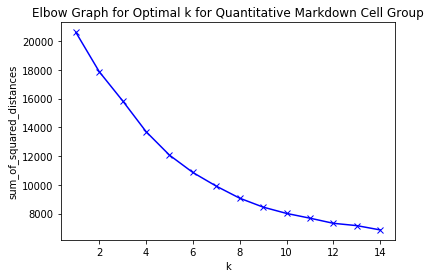

In [169]:
# plot the elbow graph to determine the optimal number of clusters
plt.plot(K, sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('sum_of_squared_distances')
plt.title('Elbow Graph for Optimal k for Quantitative Markdown Cell Group')

# Scrap